# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0k/60.0k [00:09<00:00, 6.59kFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

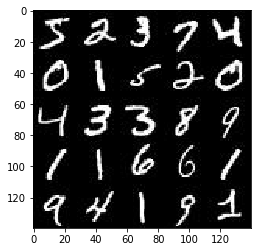

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

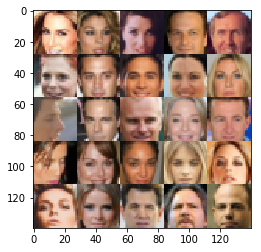

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], "inputs_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32,None,name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/usr/lo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    keep_prob = 0.8
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.nn.dropout(x1, keep_prob=keep_prob)
        relu1 = tf.maximum(alpha * x1, x1)
    
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        bn2 = tf.nn.dropout(bn2, keep_prob=keep_prob)
        relu2 = tf.maximum(alpha * bn2, bn2)
       
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        bn3 = tf.nn.dropout(bn3, keep_prob=keep_prob)
        relu3 = tf.maximum(alpha * bn3, bn3)
      
        flat = tf.reshape(relu3, (-1, 4*4*512))
        
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2

    with tf.variable_scope('generator',reuse = not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
       
        
        x2 = tf.layers.conv2d_transpose(x1, 64, 5, strides=2, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        
        x3 = tf.layers.conv2d_transpose(x2, 32, 5, strides=2, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        
        out = tf.tanh(logits)
    
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height,image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z,image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    print_every=10
    show_every = 100
    n_images = 50   
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr:learning_rate, input_real: batch_images})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0070... Generator Loss: 34.8929
Epoch 1/2... Discriminator Loss: 10.7434... Generator Loss: 38.7158
Epoch 1/2... Discriminator Loss: 0.4042... Generator Loss: 8.2664
Epoch 1/2... Discriminator Loss: 0.3969... Generator Loss: 4.8352
Epoch 1/2... Discriminator Loss: 0.3966... Generator Loss: 4.6028
Epoch 1/2... Discriminator Loss: 2.0584... Generator Loss: 0.6302
Epoch 1/2... Discriminator Loss: 1.4997... Generator Loss: 0.5971
Epoch 1/2... Discriminator Loss: 0.5824... Generator Loss: 2.4727
Epoch 1/2... Discriminator Loss: 2.7644... Generator Loss: 0.1777
Epoch 1/2... Discriminator Loss: 1.3204... Generator Loss: 1.4032


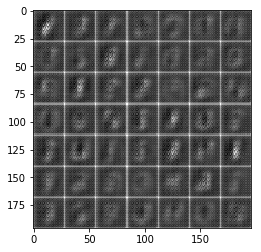

Epoch 1/2... Discriminator Loss: 1.3202... Generator Loss: 1.0312
Epoch 1/2... Discriminator Loss: 1.2670... Generator Loss: 1.0341
Epoch 1/2... Discriminator Loss: 1.2227... Generator Loss: 1.0548
Epoch 1/2... Discriminator Loss: 1.1871... Generator Loss: 1.2397
Epoch 1/2... Discriminator Loss: 1.4136... Generator Loss: 1.2810
Epoch 1/2... Discriminator Loss: 1.5624... Generator Loss: 1.5150
Epoch 1/2... Discriminator Loss: 1.2447... Generator Loss: 1.7885
Epoch 1/2... Discriminator Loss: 1.3498... Generator Loss: 1.9892
Epoch 1/2... Discriminator Loss: 1.2395... Generator Loss: 0.7607
Epoch 1/2... Discriminator Loss: 1.1316... Generator Loss: 0.8238


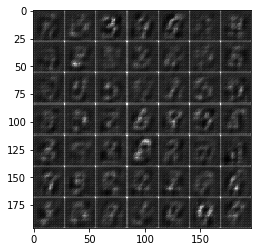

Epoch 1/2... Discriminator Loss: 1.4076... Generator Loss: 0.9246
Epoch 1/2... Discriminator Loss: 1.5782... Generator Loss: 0.6120
Epoch 1/2... Discriminator Loss: 0.8456... Generator Loss: 2.2775
Epoch 1/2... Discriminator Loss: 1.1848... Generator Loss: 0.8548
Epoch 1/2... Discriminator Loss: 1.3360... Generator Loss: 1.7323
Epoch 1/2... Discriminator Loss: 1.2094... Generator Loss: 0.9166
Epoch 1/2... Discriminator Loss: 1.1438... Generator Loss: 1.3359
Epoch 1/2... Discriminator Loss: 1.1635... Generator Loss: 0.9996
Epoch 1/2... Discriminator Loss: 1.2605... Generator Loss: 2.2388
Epoch 1/2... Discriminator Loss: 1.0717... Generator Loss: 1.1081


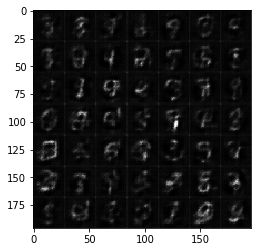

Epoch 1/2... Discriminator Loss: 1.3787... Generator Loss: 0.7659
Epoch 1/2... Discriminator Loss: 1.1094... Generator Loss: 1.1647
Epoch 1/2... Discriminator Loss: 0.9724... Generator Loss: 1.1902
Epoch 1/2... Discriminator Loss: 1.1860... Generator Loss: 1.9630
Epoch 1/2... Discriminator Loss: 1.2822... Generator Loss: 0.8650
Epoch 1/2... Discriminator Loss: 1.1134... Generator Loss: 1.0574
Epoch 1/2... Discriminator Loss: 0.9710... Generator Loss: 1.4917
Epoch 1/2... Discriminator Loss: 1.3151... Generator Loss: 0.6949
Epoch 1/2... Discriminator Loss: 1.2129... Generator Loss: 0.8565
Epoch 1/2... Discriminator Loss: 1.2226... Generator Loss: 1.5373


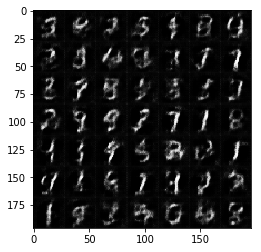

Epoch 1/2... Discriminator Loss: 1.6491... Generator Loss: 0.4323
Epoch 1/2... Discriminator Loss: 1.2474... Generator Loss: 0.8518
Epoch 1/2... Discriminator Loss: 1.1802... Generator Loss: 1.2861
Epoch 1/2... Discriminator Loss: 1.3794... Generator Loss: 1.4059
Epoch 1/2... Discriminator Loss: 1.1771... Generator Loss: 1.1879
Epoch 1/2... Discriminator Loss: 1.3519... Generator Loss: 0.8855
Epoch 1/2... Discriminator Loss: 1.4912... Generator Loss: 0.5783
Epoch 1/2... Discriminator Loss: 1.0876... Generator Loss: 1.3015
Epoch 1/2... Discriminator Loss: 1.1836... Generator Loss: 1.1152
Epoch 1/2... Discriminator Loss: 1.9179... Generator Loss: 0.3317


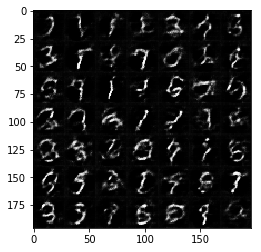

Epoch 1/2... Discriminator Loss: 1.1006... Generator Loss: 1.5296
Epoch 1/2... Discriminator Loss: 1.1513... Generator Loss: 1.7999
Epoch 1/2... Discriminator Loss: 1.1051... Generator Loss: 1.3291
Epoch 1/2... Discriminator Loss: 1.2124... Generator Loss: 0.8716
Epoch 1/2... Discriminator Loss: 1.0253... Generator Loss: 1.6771
Epoch 1/2... Discriminator Loss: 1.6676... Generator Loss: 2.2423
Epoch 1/2... Discriminator Loss: 1.1160... Generator Loss: 1.2352
Epoch 1/2... Discriminator Loss: 1.6893... Generator Loss: 0.4064
Epoch 1/2... Discriminator Loss: 1.5082... Generator Loss: 0.5680
Epoch 1/2... Discriminator Loss: 1.5377... Generator Loss: 0.6296


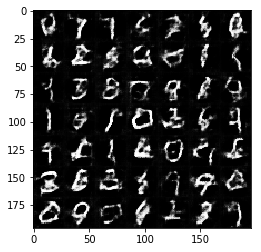

Epoch 1/2... Discriminator Loss: 1.4353... Generator Loss: 0.5980
Epoch 1/2... Discriminator Loss: 1.3749... Generator Loss: 0.5605
Epoch 1/2... Discriminator Loss: 1.3476... Generator Loss: 0.5532
Epoch 1/2... Discriminator Loss: 1.0538... Generator Loss: 1.0736
Epoch 1/2... Discriminator Loss: 1.2235... Generator Loss: 1.8288
Epoch 1/2... Discriminator Loss: 1.2776... Generator Loss: 0.7357
Epoch 1/2... Discriminator Loss: 1.1778... Generator Loss: 1.2083
Epoch 1/2... Discriminator Loss: 1.2722... Generator Loss: 1.7319
Epoch 1/2... Discriminator Loss: 1.0520... Generator Loss: 1.4817
Epoch 1/2... Discriminator Loss: 1.3157... Generator Loss: 0.7396


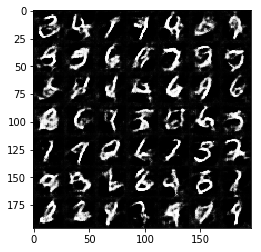

Epoch 1/2... Discriminator Loss: 1.4030... Generator Loss: 0.6065
Epoch 1/2... Discriminator Loss: 1.3619... Generator Loss: 0.7675
Epoch 1/2... Discriminator Loss: 1.1357... Generator Loss: 1.6191
Epoch 1/2... Discriminator Loss: 1.2776... Generator Loss: 0.8267
Epoch 1/2... Discriminator Loss: 1.1268... Generator Loss: 1.2332
Epoch 1/2... Discriminator Loss: 1.1267... Generator Loss: 1.1456
Epoch 1/2... Discriminator Loss: 1.3668... Generator Loss: 0.7129
Epoch 1/2... Discriminator Loss: 1.1499... Generator Loss: 1.1391
Epoch 1/2... Discriminator Loss: 1.2366... Generator Loss: 0.8265
Epoch 1/2... Discriminator Loss: 1.2871... Generator Loss: 1.0872


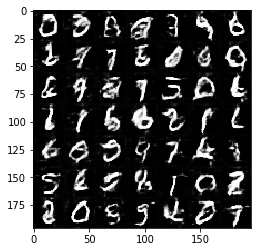

Epoch 1/2... Discriminator Loss: 0.9701... Generator Loss: 1.0287
Epoch 1/2... Discriminator Loss: 1.1596... Generator Loss: 1.1939
Epoch 1/2... Discriminator Loss: 1.1449... Generator Loss: 0.9983
Epoch 1/2... Discriminator Loss: 1.1506... Generator Loss: 0.9113
Epoch 1/2... Discriminator Loss: 1.6281... Generator Loss: 0.4992
Epoch 1/2... Discriminator Loss: 1.2402... Generator Loss: 0.6208
Epoch 1/2... Discriminator Loss: 1.5633... Generator Loss: 0.4530
Epoch 1/2... Discriminator Loss: 1.2242... Generator Loss: 0.8470
Epoch 1/2... Discriminator Loss: 1.0144... Generator Loss: 1.2203
Epoch 1/2... Discriminator Loss: 0.8897... Generator Loss: 1.6084


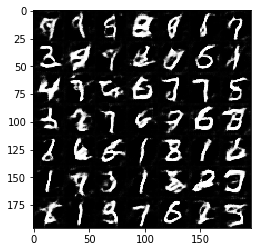

Epoch 1/2... Discriminator Loss: 1.1439... Generator Loss: 0.8803
Epoch 1/2... Discriminator Loss: 1.2465... Generator Loss: 1.4229
Epoch 1/2... Discriminator Loss: 0.9559... Generator Loss: 1.5611
Epoch 2/2... Discriminator Loss: 1.1640... Generator Loss: 1.0575
Epoch 2/2... Discriminator Loss: 1.0488... Generator Loss: 1.2893
Epoch 2/2... Discriminator Loss: 1.1461... Generator Loss: 1.3772
Epoch 2/2... Discriminator Loss: 1.0460... Generator Loss: 1.0443
Epoch 2/2... Discriminator Loss: 1.4244... Generator Loss: 0.5532
Epoch 2/2... Discriminator Loss: 1.1953... Generator Loss: 0.7667
Epoch 2/2... Discriminator Loss: 1.1295... Generator Loss: 0.9040


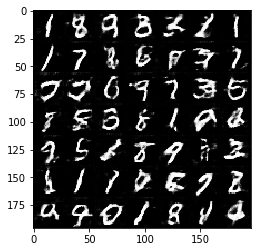

Epoch 2/2... Discriminator Loss: 2.7238... Generator Loss: 0.1624
Epoch 2/2... Discriminator Loss: 1.3065... Generator Loss: 0.6595
Epoch 2/2... Discriminator Loss: 1.0091... Generator Loss: 1.2994
Epoch 2/2... Discriminator Loss: 1.1229... Generator Loss: 0.9152
Epoch 2/2... Discriminator Loss: 1.3188... Generator Loss: 0.6279
Epoch 2/2... Discriminator Loss: 1.4229... Generator Loss: 0.5761
Epoch 2/2... Discriminator Loss: 1.3210... Generator Loss: 1.3986
Epoch 2/2... Discriminator Loss: 1.1491... Generator Loss: 0.8541
Epoch 2/2... Discriminator Loss: 1.1107... Generator Loss: 1.0761
Epoch 2/2... Discriminator Loss: 1.3260... Generator Loss: 2.1778


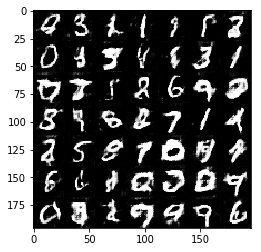

Epoch 2/2... Discriminator Loss: 0.9423... Generator Loss: 1.1747
Epoch 2/2... Discriminator Loss: 1.7083... Generator Loss: 2.1446
Epoch 2/2... Discriminator Loss: 1.2611... Generator Loss: 0.7811
Epoch 2/2... Discriminator Loss: 1.4899... Generator Loss: 0.5661
Epoch 2/2... Discriminator Loss: 1.2722... Generator Loss: 2.1570
Epoch 2/2... Discriminator Loss: 0.9580... Generator Loss: 1.3996
Epoch 2/2... Discriminator Loss: 1.5583... Generator Loss: 0.5879
Epoch 2/2... Discriminator Loss: 0.9720... Generator Loss: 1.0134
Epoch 2/2... Discriminator Loss: 1.0926... Generator Loss: 1.0805
Epoch 2/2... Discriminator Loss: 1.0088... Generator Loss: 1.1689


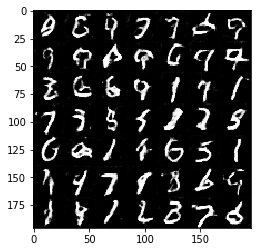

Epoch 2/2... Discriminator Loss: 0.8724... Generator Loss: 1.6124
Epoch 2/2... Discriminator Loss: 1.1195... Generator Loss: 1.3999
Epoch 2/2... Discriminator Loss: 0.8464... Generator Loss: 1.3657
Epoch 2/2... Discriminator Loss: 1.1584... Generator Loss: 0.9487
Epoch 2/2... Discriminator Loss: 1.2958... Generator Loss: 0.7606
Epoch 2/2... Discriminator Loss: 1.3286... Generator Loss: 0.6854
Epoch 2/2... Discriminator Loss: 1.0819... Generator Loss: 0.9584
Epoch 2/2... Discriminator Loss: 1.2184... Generator Loss: 1.0291
Epoch 2/2... Discriminator Loss: 1.0894... Generator Loss: 0.9130
Epoch 2/2... Discriminator Loss: 1.3012... Generator Loss: 0.8984


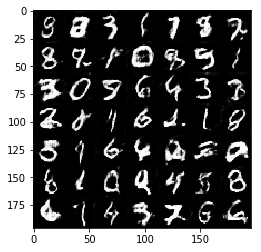

Epoch 2/2... Discriminator Loss: 1.1819... Generator Loss: 0.9964
Epoch 2/2... Discriminator Loss: 0.9734... Generator Loss: 1.0839
Epoch 2/2... Discriminator Loss: 1.1268... Generator Loss: 1.1286
Epoch 2/2... Discriminator Loss: 1.4209... Generator Loss: 0.6155
Epoch 2/2... Discriminator Loss: 1.5107... Generator Loss: 0.5482
Epoch 2/2... Discriminator Loss: 1.2395... Generator Loss: 1.1160
Epoch 2/2... Discriminator Loss: 1.2764... Generator Loss: 2.2098
Epoch 2/2... Discriminator Loss: 1.1017... Generator Loss: 1.8347
Epoch 2/2... Discriminator Loss: 1.4844... Generator Loss: 2.8681
Epoch 2/2... Discriminator Loss: 1.1373... Generator Loss: 0.9210


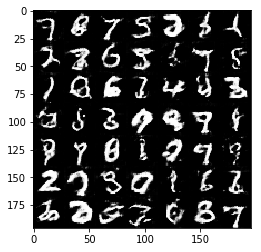

Epoch 2/2... Discriminator Loss: 1.1721... Generator Loss: 0.8405
Epoch 2/2... Discriminator Loss: 1.3895... Generator Loss: 2.8136
Epoch 2/2... Discriminator Loss: 1.3699... Generator Loss: 1.9518
Epoch 2/2... Discriminator Loss: 1.0534... Generator Loss: 1.6246
Epoch 2/2... Discriminator Loss: 1.1782... Generator Loss: 1.2775
Epoch 2/2... Discriminator Loss: 0.8539... Generator Loss: 1.7428
Epoch 2/2... Discriminator Loss: 1.0267... Generator Loss: 1.2331
Epoch 2/2... Discriminator Loss: 1.7700... Generator Loss: 3.0265
Epoch 2/2... Discriminator Loss: 1.9426... Generator Loss: 0.3532
Epoch 2/2... Discriminator Loss: 1.0093... Generator Loss: 1.7854


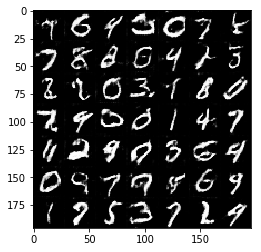

Epoch 2/2... Discriminator Loss: 1.1320... Generator Loss: 1.3994
Epoch 2/2... Discriminator Loss: 1.0896... Generator Loss: 0.9362
Epoch 2/2... Discriminator Loss: 1.0089... Generator Loss: 0.9734
Epoch 2/2... Discriminator Loss: 0.9831... Generator Loss: 1.1220
Epoch 2/2... Discriminator Loss: 1.7583... Generator Loss: 2.6906
Epoch 2/2... Discriminator Loss: 1.1301... Generator Loss: 0.7624
Epoch 2/2... Discriminator Loss: 1.1360... Generator Loss: 1.2956
Epoch 2/2... Discriminator Loss: 0.8803... Generator Loss: 1.2688
Epoch 2/2... Discriminator Loss: 1.0307... Generator Loss: 1.1554
Epoch 2/2... Discriminator Loss: 1.2596... Generator Loss: 0.9285


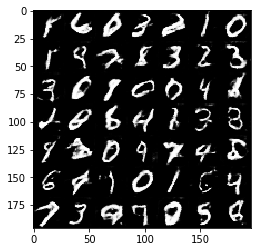

Epoch 2/2... Discriminator Loss: 1.1221... Generator Loss: 1.0574
Epoch 2/2... Discriminator Loss: 1.0042... Generator Loss: 1.4404
Epoch 2/2... Discriminator Loss: 0.9725... Generator Loss: 1.0154
Epoch 2/2... Discriminator Loss: 1.2074... Generator Loss: 0.7165
Epoch 2/2... Discriminator Loss: 1.2945... Generator Loss: 0.7671
Epoch 2/2... Discriminator Loss: 0.8993... Generator Loss: 1.4781
Epoch 2/2... Discriminator Loss: 0.9018... Generator Loss: 1.4983
Epoch 2/2... Discriminator Loss: 1.5207... Generator Loss: 0.5351
Epoch 2/2... Discriminator Loss: 1.0295... Generator Loss: 1.0524
Epoch 2/2... Discriminator Loss: 1.0232... Generator Loss: 1.3860


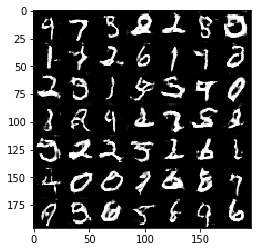

Epoch 2/2... Discriminator Loss: 1.1047... Generator Loss: 1.1687
Epoch 2/2... Discriminator Loss: 1.3176... Generator Loss: 0.6808
Epoch 2/2... Discriminator Loss: 0.8801... Generator Loss: 1.7058
Epoch 2/2... Discriminator Loss: 1.0521... Generator Loss: 1.0664
Epoch 2/2... Discriminator Loss: 1.3138... Generator Loss: 0.6288
Epoch 2/2... Discriminator Loss: 1.0381... Generator Loss: 1.7738
Epoch 2/2... Discriminator Loss: 0.9734... Generator Loss: 2.0142
Epoch 2/2... Discriminator Loss: 1.1187... Generator Loss: 0.9139
Epoch 2/2... Discriminator Loss: 0.8152... Generator Loss: 1.5299
Epoch 2/2... Discriminator Loss: 1.2601... Generator Loss: 0.6733


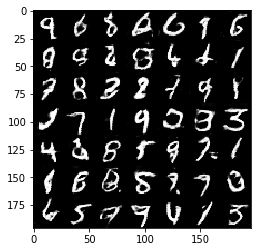

Epoch 2/2... Discriminator Loss: 1.1595... Generator Loss: 0.7461
Epoch 2/2... Discriminator Loss: 1.3186... Generator Loss: 0.6712
Epoch 2/2... Discriminator Loss: 1.4989... Generator Loss: 0.4896
Epoch 2/2... Discriminator Loss: 0.8499... Generator Loss: 1.5538
Epoch 2/2... Discriminator Loss: 1.1197... Generator Loss: 1.0843
Epoch 2/2... Discriminator Loss: 0.9435... Generator Loss: 1.0950
Epoch 2/2... Discriminator Loss: 1.1467... Generator Loss: 0.9852


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9473... Generator Loss: 24.8391
Epoch 1/1... Discriminator Loss: 0.6585... Generator Loss: 9.5140
Epoch 1/1... Discriminator Loss: 1.1337... Generator Loss: 2.9700
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 1.1944
Epoch 1/1... Discriminator Loss: 1.8656... Generator Loss: 0.5354
Epoch 1/1... Discriminator Loss: 0.8837... Generator Loss: 1.6026
Epoch 1/1... Discriminator Loss: 3.1963... Generator Loss: 5.5680
Epoch 1/1... Discriminator Loss: 1.0522... Generator Loss: 1.2692
Epoch 1/1... Discriminator Loss: 1.7670... Generator Loss: 0.3959
Epoch 1/1... Discriminator Loss: 1.7113... Generator Loss: 0.4703


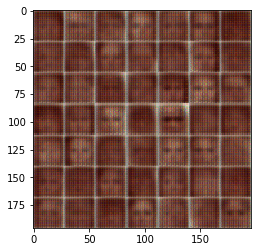

Epoch 1/1... Discriminator Loss: 1.8893... Generator Loss: 3.8205
Epoch 1/1... Discriminator Loss: 2.5450... Generator Loss: 5.2396
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.9563... Generator Loss: 0.3777
Epoch 1/1... Discriminator Loss: 1.5749... Generator Loss: 1.0609
Epoch 1/1... Discriminator Loss: 2.0856... Generator Loss: 0.3525
Epoch 1/1... Discriminator Loss: 1.5391... Generator Loss: 1.6336
Epoch 1/1... Discriminator Loss: 1.8698... Generator Loss: 2.7148
Epoch 1/1... Discriminator Loss: 1.0916... Generator Loss: 0.9459
Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 1.5014


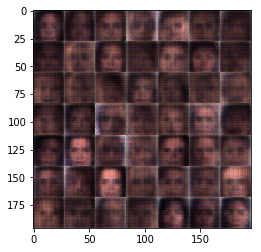

Epoch 1/1... Discriminator Loss: 1.5941... Generator Loss: 1.2823
Epoch 1/1... Discriminator Loss: 0.8734... Generator Loss: 2.0346
Epoch 1/1... Discriminator Loss: 1.1511... Generator Loss: 1.5125
Epoch 1/1... Discriminator Loss: 1.5655... Generator Loss: 0.8444
Epoch 1/1... Discriminator Loss: 1.1299... Generator Loss: 0.9447
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 1.3295
Epoch 1/1... Discriminator Loss: 1.2559... Generator Loss: 1.0935
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.9047
Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 1.0407


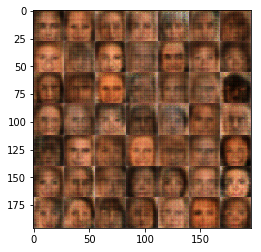

Epoch 1/1... Discriminator Loss: 1.2884... Generator Loss: 0.9999
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.8285
Epoch 1/1... Discriminator Loss: 1.8030... Generator Loss: 0.5378
Epoch 1/1... Discriminator Loss: 1.4964... Generator Loss: 1.4077
Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 1.0558
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.9659
Epoch 1/1... Discriminator Loss: 1.2092... Generator Loss: 0.9599
Epoch 1/1... Discriminator Loss: 1.4991... Generator Loss: 0.5607
Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 1.2504
Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 0.9055


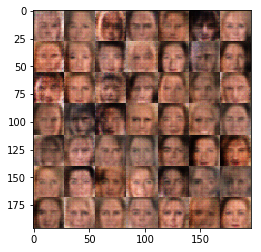

Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 1.1017
Epoch 1/1... Discriminator Loss: 1.7280... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.2799... Generator Loss: 1.0194
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.7385
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.1909... Generator Loss: 1.0665
Epoch 1/1... Discriminator Loss: 1.1398... Generator Loss: 1.1230
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.9423


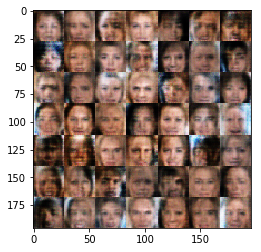

Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.5458
Epoch 1/1... Discriminator Loss: 0.8871... Generator Loss: 1.0985
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.6110
Epoch 1/1... Discriminator Loss: 1.1909... Generator Loss: 0.9446
Epoch 1/1... Discriminator Loss: 1.1098... Generator Loss: 0.8565
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 1.0089
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 1.0154
Epoch 1/1... Discriminator Loss: 1.5908... Generator Loss: 1.1467
Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 1.0610


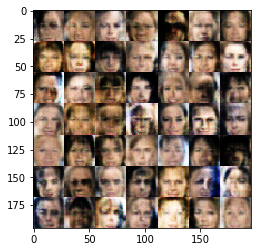

Epoch 1/1... Discriminator Loss: 1.1477... Generator Loss: 1.2425
Epoch 1/1... Discriminator Loss: 0.9692... Generator Loss: 1.5340
Epoch 1/1... Discriminator Loss: 0.8347... Generator Loss: 1.2273
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.8986
Epoch 1/1... Discriminator Loss: 0.9427... Generator Loss: 1.0404
Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 0.6813... Generator Loss: 2.0141
Epoch 1/1... Discriminator Loss: 1.0175... Generator Loss: 3.0160
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 1.9723


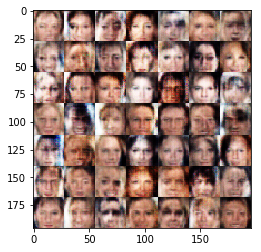

Epoch 1/1... Discriminator Loss: 0.9428... Generator Loss: 1.4739
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 1.4475
Epoch 1/1... Discriminator Loss: 1.4800... Generator Loss: 0.5590
Epoch 1/1... Discriminator Loss: 1.0198... Generator Loss: 1.1576
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 1.0236
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 1.2417
Epoch 1/1... Discriminator Loss: 1.2947... Generator Loss: 0.6813
Epoch 1/1... Discriminator Loss: 1.6664... Generator Loss: 0.4089
Epoch 1/1... Discriminator Loss: 1.0141... Generator Loss: 1.3674
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.5916


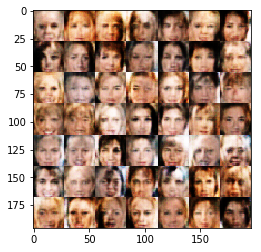

Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 1.0782
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.1305... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 1.3292
Epoch 1/1... Discriminator Loss: 0.9290... Generator Loss: 1.5179
Epoch 1/1... Discriminator Loss: 0.7611... Generator Loss: 1.4482
Epoch 1/1... Discriminator Loss: 0.9188... Generator Loss: 1.9947
Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 0.9463
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.7044


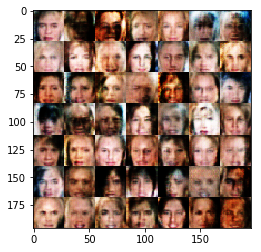

Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 0.6453
Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 1.2079
Epoch 1/1... Discriminator Loss: 1.8339... Generator Loss: 0.3711
Epoch 1/1... Discriminator Loss: 0.9762... Generator Loss: 1.0588
Epoch 1/1... Discriminator Loss: 1.4974... Generator Loss: 0.5468
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.6143
Epoch 1/1... Discriminator Loss: 0.7371... Generator Loss: 1.5473
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 3.4376


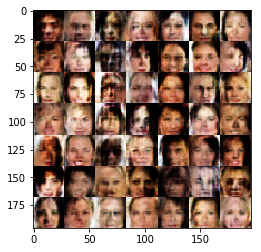

Epoch 1/1... Discriminator Loss: 0.8234... Generator Loss: 1.9698
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 0.8985
Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 0.6870... Generator Loss: 2.9897
Epoch 1/1... Discriminator Loss: 1.1070... Generator Loss: 1.0334
Epoch 1/1... Discriminator Loss: 1.0430... Generator Loss: 2.9177
Epoch 1/1... Discriminator Loss: 1.1347... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 0.7938... Generator Loss: 2.0503
Epoch 1/1... Discriminator Loss: 0.8934... Generator Loss: 1.2670
Epoch 1/1... Discriminator Loss: 0.9233... Generator Loss: 1.1271


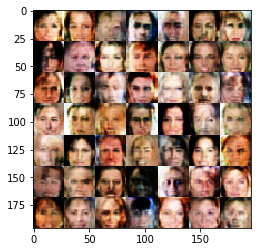

Epoch 1/1... Discriminator Loss: 1.5185... Generator Loss: 0.4857
Epoch 1/1... Discriminator Loss: 1.0735... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 0.8142... Generator Loss: 1.5692
Epoch 1/1... Discriminator Loss: 0.8239... Generator Loss: 1.3835
Epoch 1/1... Discriminator Loss: 1.0999... Generator Loss: 1.8326
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 2.0508
Epoch 1/1... Discriminator Loss: 0.8003... Generator Loss: 2.2193
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.5740
Epoch 1/1... Discriminator Loss: 0.8155... Generator Loss: 1.3340
Epoch 1/1... Discriminator Loss: 0.7740... Generator Loss: 1.4439


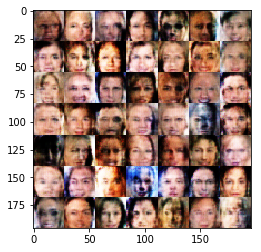

Epoch 1/1... Discriminator Loss: 1.9368... Generator Loss: 3.6741
Epoch 1/1... Discriminator Loss: 1.0294... Generator Loss: 2.6865
Epoch 1/1... Discriminator Loss: 0.9391... Generator Loss: 1.3260
Epoch 1/1... Discriminator Loss: 0.7353... Generator Loss: 1.7176
Epoch 1/1... Discriminator Loss: 0.6080... Generator Loss: 2.7586
Epoch 1/1... Discriminator Loss: 1.6041... Generator Loss: 1.0748
Epoch 1/1... Discriminator Loss: 1.1232... Generator Loss: 0.9324
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.6307
Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.4998


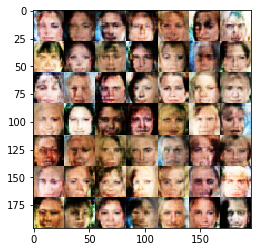

Epoch 1/1... Discriminator Loss: 0.9939... Generator Loss: 4.1355
Epoch 1/1... Discriminator Loss: 2.0534... Generator Loss: 0.2570
Epoch 1/1... Discriminator Loss: 0.9387... Generator Loss: 1.9310
Epoch 1/1... Discriminator Loss: 1.1322... Generator Loss: 2.6046
Epoch 1/1... Discriminator Loss: 0.6683... Generator Loss: 1.6932
Epoch 1/1... Discriminator Loss: 0.9056... Generator Loss: 1.3705
Epoch 1/1... Discriminator Loss: 0.8039... Generator Loss: 1.5809
Epoch 1/1... Discriminator Loss: 0.9356... Generator Loss: 1.3397
Epoch 1/1... Discriminator Loss: 1.9764... Generator Loss: 2.9074
Epoch 1/1... Discriminator Loss: 0.9234... Generator Loss: 1.2362


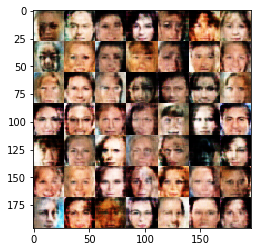

Epoch 1/1... Discriminator Loss: 1.0656... Generator Loss: 0.9039
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.9821
Epoch 1/1... Discriminator Loss: 1.0138... Generator Loss: 1.4459
Epoch 1/1... Discriminator Loss: 0.8875... Generator Loss: 1.5342
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.5382
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 1.2323
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 1.6326
Epoch 1/1... Discriminator Loss: 1.5218... Generator Loss: 0.6403
Epoch 1/1... Discriminator Loss: 0.7944... Generator Loss: 1.7558
Epoch 1/1... Discriminator Loss: 1.0910... Generator Loss: 0.8677


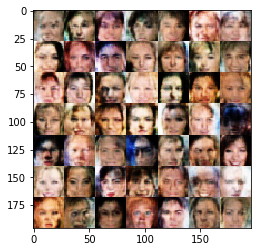

Epoch 1/1... Discriminator Loss: 1.0719... Generator Loss: 1.5324
Epoch 1/1... Discriminator Loss: 0.8820... Generator Loss: 1.8271
Epoch 1/1... Discriminator Loss: 0.7956... Generator Loss: 1.4123
Epoch 1/1... Discriminator Loss: 0.8463... Generator Loss: 1.9314
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 3.9246
Epoch 1/1... Discriminator Loss: 1.5321... Generator Loss: 2.8046
Epoch 1/1... Discriminator Loss: 1.0309... Generator Loss: 2.4234
Epoch 1/1... Discriminator Loss: 1.1292... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 1.0861... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 0.5852... Generator Loss: 1.9785


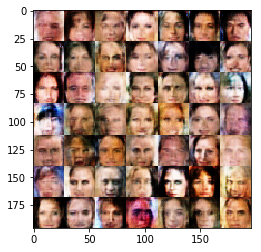

Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 2.5711
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 1.7608
Epoch 1/1... Discriminator Loss: 0.8116... Generator Loss: 2.1382
Epoch 1/1... Discriminator Loss: 0.8388... Generator Loss: 2.3383
Epoch 1/1... Discriminator Loss: 0.6511... Generator Loss: 2.3867
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 0.9529... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 0.8532... Generator Loss: 1.3878
Epoch 1/1... Discriminator Loss: 1.0177... Generator Loss: 0.9299
Epoch 1/1... Discriminator Loss: 0.9800... Generator Loss: 0.8835


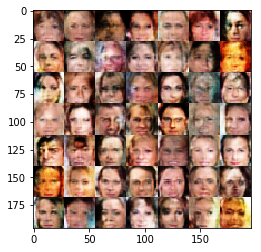

Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.0919... Generator Loss: 0.8755
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 1.3360
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 1.6135
Epoch 1/1... Discriminator Loss: 0.6238... Generator Loss: 1.7871
Epoch 1/1... Discriminator Loss: 0.8335... Generator Loss: 1.5055
Epoch 1/1... Discriminator Loss: 0.6249... Generator Loss: 2.3459
Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 3.0223
Epoch 1/1... Discriminator Loss: 1.0869... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 1.9428... Generator Loss: 0.2692


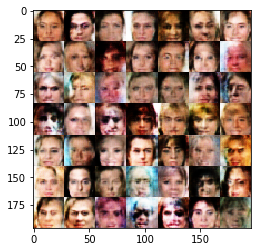

Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 1.3771
Epoch 1/1... Discriminator Loss: 1.0442... Generator Loss: 0.9005
Epoch 1/1... Discriminator Loss: 0.8684... Generator Loss: 1.2629
Epoch 1/1... Discriminator Loss: 0.9477... Generator Loss: 2.9711
Epoch 1/1... Discriminator Loss: 0.9215... Generator Loss: 1.6374
Epoch 1/1... Discriminator Loss: 0.8471... Generator Loss: 1.2482
Epoch 1/1... Discriminator Loss: 0.8891... Generator Loss: 1.1420
Epoch 1/1... Discriminator Loss: 0.9905... Generator Loss: 3.3632
Epoch 1/1... Discriminator Loss: 0.8943... Generator Loss: 1.3290
Epoch 1/1... Discriminator Loss: 0.9872... Generator Loss: 1.1600


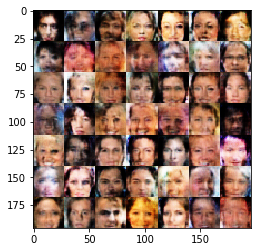

Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 0.7832... Generator Loss: 1.7037
Epoch 1/1... Discriminator Loss: 1.7400... Generator Loss: 0.3762
Epoch 1/1... Discriminator Loss: 0.7743... Generator Loss: 2.4915
Epoch 1/1... Discriminator Loss: 0.9491... Generator Loss: 2.5773
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.5756
Epoch 1/1... Discriminator Loss: 0.7908... Generator Loss: 1.2075
Epoch 1/1... Discriminator Loss: 0.8549... Generator Loss: 2.0309
Epoch 1/1... Discriminator Loss: 2.1541... Generator Loss: 0.2696


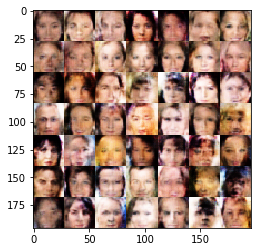

Epoch 1/1... Discriminator Loss: 0.9158... Generator Loss: 1.9059
Epoch 1/1... Discriminator Loss: 1.0260... Generator Loss: 1.0544
Epoch 1/1... Discriminator Loss: 0.8238... Generator Loss: 1.4811
Epoch 1/1... Discriminator Loss: 0.9471... Generator Loss: 2.2301
Epoch 1/1... Discriminator Loss: 1.1580... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 0.9317... Generator Loss: 1.1753
Epoch 1/1... Discriminator Loss: 0.8806... Generator Loss: 1.2718
Epoch 1/1... Discriminator Loss: 0.8637... Generator Loss: 1.3062
Epoch 1/1... Discriminator Loss: 0.8286... Generator Loss: 1.4696
Epoch 1/1... Discriminator Loss: 0.7292... Generator Loss: 1.3718


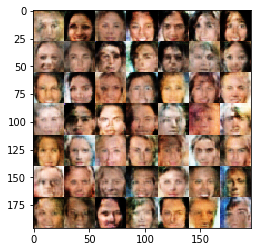

Epoch 1/1... Discriminator Loss: 1.1034... Generator Loss: 0.9316
Epoch 1/1... Discriminator Loss: 0.9402... Generator Loss: 1.1345
Epoch 1/1... Discriminator Loss: 0.9163... Generator Loss: 1.1133
Epoch 1/1... Discriminator Loss: 0.9866... Generator Loss: 2.4566
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 0.9665... Generator Loss: 1.5622
Epoch 1/1... Discriminator Loss: 0.8563... Generator Loss: 1.6606
Epoch 1/1... Discriminator Loss: 0.7867... Generator Loss: 1.3234
Epoch 1/1... Discriminator Loss: 1.5797... Generator Loss: 0.4281
Epoch 1/1... Discriminator Loss: 0.9621... Generator Loss: 1.6271


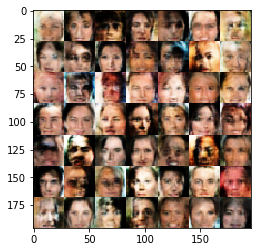

Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 1.8407
Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.5965
Epoch 1/1... Discriminator Loss: 1.5483... Generator Loss: 0.5317
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 1.6877
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 3.0836
Epoch 1/1... Discriminator Loss: 0.8704... Generator Loss: 1.1221
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.5492
Epoch 1/1... Discriminator Loss: 1.1344... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 0.9159... Generator Loss: 1.7419
Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 1.9308


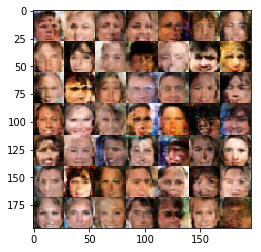

Epoch 1/1... Discriminator Loss: 0.7337... Generator Loss: 2.0040
Epoch 1/1... Discriminator Loss: 1.0007... Generator Loss: 1.0593
Epoch 1/1... Discriminator Loss: 1.7524... Generator Loss: 2.7271
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 0.7446
Epoch 1/1... Discriminator Loss: 1.0536... Generator Loss: 1.9373
Epoch 1/1... Discriminator Loss: 1.0113... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 2.1090
Epoch 1/1... Discriminator Loss: 0.6301... Generator Loss: 1.9301
Epoch 1/1... Discriminator Loss: 0.5697... Generator Loss: 2.3389
Epoch 1/1... Discriminator Loss: 0.7784... Generator Loss: 1.5819


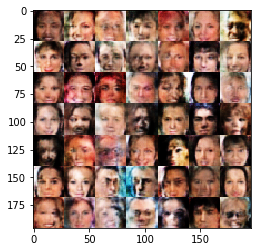

Epoch 1/1... Discriminator Loss: 1.1104... Generator Loss: 1.4030
Epoch 1/1... Discriminator Loss: 0.9159... Generator Loss: 0.9477
Epoch 1/1... Discriminator Loss: 0.8274... Generator Loss: 1.1544
Epoch 1/1... Discriminator Loss: 0.9148... Generator Loss: 2.1952
Epoch 1/1... Discriminator Loss: 0.6765... Generator Loss: 2.0145
Epoch 1/1... Discriminator Loss: 1.0150... Generator Loss: 0.9056
Epoch 1/1... Discriminator Loss: 0.8606... Generator Loss: 1.2933
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 0.8701... Generator Loss: 1.1877
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.6843


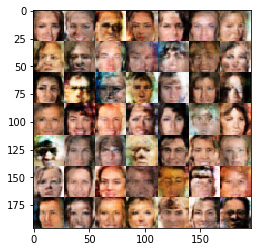

Epoch 1/1... Discriminator Loss: 0.8334... Generator Loss: 1.3372
Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.5115... Generator Loss: 0.5169
Epoch 1/1... Discriminator Loss: 0.8444... Generator Loss: 1.3380
Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 1.1248
Epoch 1/1... Discriminator Loss: 1.2567... Generator Loss: 2.4690
Epoch 1/1... Discriminator Loss: 0.7848... Generator Loss: 1.4791
Epoch 1/1... Discriminator Loss: 0.9157... Generator Loss: 1.2098
Epoch 1/1... Discriminator Loss: 0.7418... Generator Loss: 1.4307
Epoch 1/1... Discriminator Loss: 1.9903... Generator Loss: 2.6011


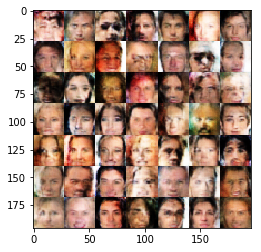

Epoch 1/1... Discriminator Loss: 0.7915... Generator Loss: 1.8607
Epoch 1/1... Discriminator Loss: 1.4773... Generator Loss: 0.5078
Epoch 1/1... Discriminator Loss: 1.1610... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 1.6566... Generator Loss: 0.4454
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 1.9175
Epoch 1/1... Discriminator Loss: 0.9785... Generator Loss: 2.3360
Epoch 1/1... Discriminator Loss: 0.9322... Generator Loss: 1.1677
Epoch 1/1... Discriminator Loss: 0.9254... Generator Loss: 0.9722
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.6130
Epoch 1/1... Discriminator Loss: 0.9924... Generator Loss: 0.9949


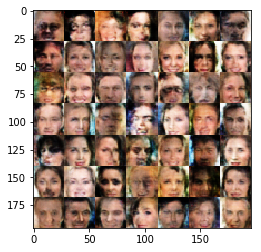

Epoch 1/1... Discriminator Loss: 0.8397... Generator Loss: 1.9471
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 1.6681
Epoch 1/1... Discriminator Loss: 0.8819... Generator Loss: 1.3813
Epoch 1/1... Discriminator Loss: 0.8918... Generator Loss: 1.6875
Epoch 1/1... Discriminator Loss: 0.9985... Generator Loss: 1.1042
Epoch 1/1... Discriminator Loss: 1.6171... Generator Loss: 0.5122
Epoch 1/1... Discriminator Loss: 0.9357... Generator Loss: 1.1148
Epoch 1/1... Discriminator Loss: 0.9707... Generator Loss: 0.9620
Epoch 1/1... Discriminator Loss: 2.0169... Generator Loss: 2.7361
Epoch 1/1... Discriminator Loss: 0.7536... Generator Loss: 1.9500


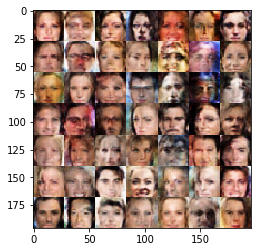

Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 0.6173... Generator Loss: 2.2926
Epoch 1/1... Discriminator Loss: 0.7501... Generator Loss: 1.6060
Epoch 1/1... Discriminator Loss: 0.8554... Generator Loss: 2.0549
Epoch 1/1... Discriminator Loss: 0.7647... Generator Loss: 1.9182
Epoch 1/1... Discriminator Loss: 0.8743... Generator Loss: 2.0092
Epoch 1/1... Discriminator Loss: 1.6352... Generator Loss: 0.4252
Epoch 1/1... Discriminator Loss: 0.8475... Generator Loss: 1.5020
Epoch 1/1... Discriminator Loss: 0.8413... Generator Loss: 1.8029
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 2.1475


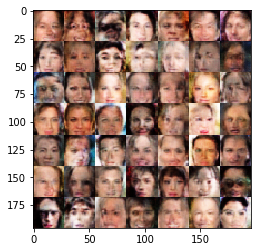

Epoch 1/1... Discriminator Loss: 0.8600... Generator Loss: 1.5675
Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 2.0535
Epoch 1/1... Discriminator Loss: 0.9825... Generator Loss: 1.7416
Epoch 1/1... Discriminator Loss: 1.1170... Generator Loss: 1.1003
Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 3.0183
Epoch 1/1... Discriminator Loss: 0.8687... Generator Loss: 1.5577
Epoch 1/1... Discriminator Loss: 0.7820... Generator Loss: 1.6038
Epoch 1/1... Discriminator Loss: 1.0268... Generator Loss: 1.0427
Epoch 1/1... Discriminator Loss: 0.9698... Generator Loss: 1.0965
Epoch 1/1... Discriminator Loss: 1.5536... Generator Loss: 0.5606


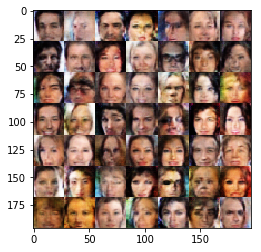

Epoch 1/1... Discriminator Loss: 0.8192... Generator Loss: 1.5929
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 2.7043
Epoch 1/1... Discriminator Loss: 0.8658... Generator Loss: 1.1443
Epoch 1/1... Discriminator Loss: 1.0661... Generator Loss: 2.0882
Epoch 1/1... Discriminator Loss: 0.8966... Generator Loss: 1.6764
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 0.7753... Generator Loss: 1.6903
Epoch 1/1... Discriminator Loss: 0.9573... Generator Loss: 1.3731
Epoch 1/1... Discriminator Loss: 1.0327... Generator Loss: 0.8425
Epoch 1/1... Discriminator Loss: 1.0611... Generator Loss: 0.8402


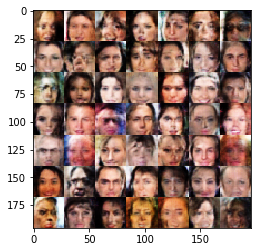

Epoch 1/1... Discriminator Loss: 0.9682... Generator Loss: 1.2444
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.5956
Epoch 1/1... Discriminator Loss: 0.9182... Generator Loss: 2.3389
Epoch 1/1... Discriminator Loss: 0.9687... Generator Loss: 1.3137
Epoch 1/1... Discriminator Loss: 0.9151... Generator Loss: 1.3262
Epoch 1/1... Discriminator Loss: 1.5044... Generator Loss: 0.5561


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.